In [5]:
pip install pandas

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------- ----------------------- 4.5/10.8 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  10.7/10.8 MB 26.8 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 22.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/14.9 MB ? eta -:--:--
   -------------- ------------------------- 5.2/14.9 MB 12.7 MB/s eta 0:00:01
   ---------------------------------------  14.7/14.9 MB 25.6 MB/s eta 0:00:01
   ---------------------------------------- 14.9/14.9 MB 24.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np

In [14]:
# Load datasets

# Transaction-level monthly sales (1% population sample)
sales = pd.read_csv(
    "system2_case_study_transaction_data_monthly_sales_by_locationid.csv",
    parse_dates=["period_start", "period_end"]
)

# Store open / close dates
location_info = pd.read_csv(
    "system2_case_study_transaction_data_location_info.csv",
    parse_dates=["est_open_date", "est_close_date"]
)


web_locations = pd.read_csv(
    "system2_case_study_webscrape_data_locations.csv"
)


# Reported comparable sales (ground truth through Q3-2022)
reported = pd.read_excel(
    "system2_case_study_reported_numbers.xlsx"
)

In [15]:
len(sales)

38867

In [16]:
sales.describe()

,locationid,period_start,period_end,amount
count,38867.000000,38867,38867,38838.000000
mean,1499.764041,2021-10-05 23:26:34.885121024,2021-11-04 10:24:36.975326208,2012.116907
min,1.000000,2019-08-01 00:00:00,2019-08-31 00:00:00,0.899927
25%,433.000000,2020-10-01 00:00:00,2020-10-31 00:00:00,537.679901
50%,749.000000,2021-10-01 00:00:00,2021-10-31 00:00:00,1214.767085
75%,1123.000000,2022-11-01 00:00:00,2022-11-30 00:00:00,2352.502316
max,8905.000000,2023-12-01 00:00:00,2023-12-31 00:00:00,167412.583117
std,1846.816925,NaN,NaN,3379.333835


In [17]:
reported.describe()

,period_end_dt,reported_yoy
count,27,27.000000
mean,2019-07-01 00:00:00,0.033667
min,2016-03-31 00:00:00,-0.524000
25%,2017-11-15 00:00:00,-0.030500
50%,2019-06-30 00:00:00,-0.014000
75%,2021-02-14 00:00:00,0.022500
max,2022-09-30 00:00:00,1.183000
std,NaN,0.267718


In [20]:
len(location_info)

898

In [21]:
len(web_locations)

747

In [22]:
# -----------------------------------
# 3. Clean Reported Comparable Sales
# -----------------------------------

if reported["reported_yoy"].dtype == object:
    reported["reported_yoy"] = (
        reported["reported_yoy"]
        .str.replace("%", "", regex=False)
        .astype(float)
    )
else:
    reported["reported_yoy"] = reported["reported_yoy"].astype(float)

reported["period_end_dt"] = pd.to_datetime(reported["period_end_dt"])
reported = reported.sort_values("period_end_dt")

reported["quarter"] = reported["period_end_dt"].dt.to_period("Q")
reported["year"] = reported["period_end_dt"].dt.year
reported["qtr"] = reported["period_end_dt"].dt.quarter


In [23]:
reported.head(5)

,entity,metric,period_end_dt,reported_yoy,quarter,year,qtr
0,PRTY,"Brand Comparable Sales Growth, %",2016-03-31,-0.015,2016Q1,2016,1
1,PRTY,"Brand Comparable Sales Growth, %",2016-06-30,0.038,2016Q2,2016,2
2,PRTY,"Brand Comparable Sales Growth, %",2016-09-30,0.012,2016Q3,2016,3
3,PRTY,"Brand Comparable Sales Growth, %",2016-12-31,-0.035,2016Q4,2016,4
4,PRTY,"Brand Comparable Sales Growth, %",2017-03-31,0.017,2017Q1,2017,1


In [24]:
# -----------------------------------
# 4. Build Statistical Q4 Forecast
#    Using Historical Q4 vs Q3 Behavior
# -----------------------------------

# Lag prior quarter comps
reported["prev_qtr_comp"] = reported["reported_yoy"].shift(1)

# Compute Q4 delta relative to Q3
reported["q4_delta"] = np.where(
    reported["qtr"] == 4,
    reported["reported_yoy"] - reported["prev_qtr_comp"],
    np.nan
)

# Historical average Q4 seasonal delta
avg_q4_delta = reported["q4_delta"].mean()
print(f'Average Q4 Delta: {avg_q4_delta}')


# Last reported quarter: Q3-2022
q3_2022_comp = reported.loc[reported["period_end_dt"] == "2022-09-30","reported_yoy"].values[0]
print(f'Q3 2022 Comp: {q3_2022_comp}')

# Baseline statistical forecast
stat_forecast_q4_2022 = q3_2022_comp + avg_q4_delta
print(f'Stat Forecast q4 2022:{stat_forecast_q4_2022}')

Average Q4 Delta: -0.01966666666666667
Q3 2022 Comp: -0.032
Stat Forecast q4 2022:-0.051666666666666666


In [29]:
reported.tail(5)

,entity,metric,period_end_dt,reported_yoy,quarter,year,qtr,prev_qtr_comp,q4_delta
22,PRTY,"Brand Comparable Sales Growth, %",2021-09-30,0.075,2021Q3,2021,3,1.183,NaN
23,PRTY,"Brand Comparable Sales Growth, %",2021-12-31,0.178,2021Q4,2021,4,0.075,0.103
24,PRTY,"Brand Comparable Sales Growth, %",2022-03-31,0.021,2022Q1,2022,1,0.178,NaN
25,PRTY,"Brand Comparable Sales Growth, %",2022-06-30,-0.056,2022Q2,2022,2,0.021,NaN
26,PRTY,"Brand Comparable Sales Growth, %",2022-09-30,-0.032,2022Q3,2022,3,-0.056,NaN


In [26]:
# -----------------------------------
# 5. Transaction-Based Q4 Estimate
# -----------------------------------

# Define Q4 windows
q4_2021_start = pd.Timestamp("2021-10-01")
q4_2021_end   = pd.Timestamp("2021-12-31")
q4_2022_start = pd.Timestamp("2022-10-01")
q4_2022_end   = pd.Timestamp("2022-12-31")

# Filter sales to Q4 2021 and Q4 2022
sales_q4 = sales[
    (
        (sales["period_start"] >= q4_2021_start) &
        (sales["period_end"] <= q4_2021_end)
    ) |
    (
        (sales["period_start"] >= q4_2022_start) &
        (sales["period_end"] <= q4_2022_end)
    )
]

# Attach store open/close info
sales_q4 = sales_q4.merge(
    location_info,
    on="locationid",
    how="left"
)

# Comparable store definition
open_before_2021 = sales_q4["est_open_date"] <= q4_2021_start
not_closed_early = (
    sales_q4["est_close_date"].isna() |
    (sales_q4["est_close_date"] >= q4_2022_end)
)

comp_sales = sales_q4[open_before_2021 & not_closed_early]

# Aggregate quarterly sales
comp_sales["year"] = comp_sales["period_start"].dt.year

q4_sales = (
    comp_sales
    .groupby("year")["amount"]
    .sum()
    .reset_index()
)

# Extract values
sales_2021 = q4_sales.loc[q4_sales["year"] == 2021, "amount"].values[0]
sales_2022 = q4_sales.loc[q4_sales["year"] == 2022, "amount"].values[0]

# Transaction-implied comp
transaction_comp_q4_2022 = (sales_2022 / sales_2021 - 1) * 100

C:\Users\13473\AppData\Local\Temp\ipykernel_17932\2053278463.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_sales["year"] = comp_sales["period_start"].dt.year


In [27]:
print(f'Transaction-implied comparable {transaction_comp_q4_2022}')

Transaction-implied comparable -11.01427049608239


In [27]:
sales_q4

,symbol,locationid,period_start,period_end,label,amount,est_open_date,est_close_date
0,NYSE:PRTY,1,2021-10-01,2021-10-31,2021-MS10,9695.196287,2017-01-01,2024-09-01
1,NYSE:PRTY,16,2021-10-01,2021-10-31,2021-MS10,730.967447,2017-01-01,2024-09-01
2,NYSE:PRTY,16,2021-10-01,2021-10-31,2021-MS10,730.967447,2017-01-01,2024-06-01
3,NYSE:PRTY,18,2021-10-01,2021-10-31,2021-MS10,1409.749874,2021-05-01,2022-12-01
4,NYSE:PRTY,18,2021-10-01,2021-10-31,2021-MS10,1409.749874,2017-01-01,2024-09-01
...,...,...,...,...,...,...,...,...
4853,NYSE:PRTY,994,2022-12-01,2022-12-31,2022-MS12,795.905495,2018-09-01,2024-09-01
4854,NYSE:PRTY,995,2022-12-01,2022-12-31,2022-MS12,1500.890521,2017-01-01,2024-09-01
4855,NYSE:PRTY,996,2022-12-01,2022-12-31,2022-MS12,834.500907,2020-12-01,2024-09-01
4856,NYSE:PRTY,997,2022-12-01,2022-12-31,2022-MS12,1001.689931,2020-10-01,2024-09-01


In [28]:
comp_sales

,symbol,locationid,period_start,period_end,label,amount,est_open_date,est_close_date,year
0,NYSE:PRTY,1,2021-10-01,2021-10-31,2021-MS10,9695.196287,2017-01-01,2024-09-01,2021
1,NYSE:PRTY,16,2021-10-01,2021-10-31,2021-MS10,730.967447,2017-01-01,2024-09-01,2021
2,NYSE:PRTY,16,2021-10-01,2021-10-31,2021-MS10,730.967447,2017-01-01,2024-06-01,2021
4,NYSE:PRTY,18,2021-10-01,2021-10-31,2021-MS10,1409.749874,2017-01-01,2024-09-01,2021
5,NYSE:PRTY,18,2021-10-01,2021-10-31,2021-MS10,1409.749874,2017-01-01,2024-06-01,2021
...,...,...,...,...,...,...,...,...,...
4853,NYSE:PRTY,994,2022-12-01,2022-12-31,2022-MS12,795.905495,2018-09-01,2024-09-01,2022
4854,NYSE:PRTY,995,2022-12-01,2022-12-31,2022-MS12,1500.890521,2017-01-01,2024-09-01,2022
4855,NYSE:PRTY,996,2022-12-01,2022-12-31,2022-MS12,834.500907,2020-12-01,2024-09-01,2022
4856,NYSE:PRTY,997,2022-12-01,2022-12-31,2022-MS12,1001.689931,2020-10-01,2024-09-01,2022


In [30]:
q4_sales

,year,amount
0,2021,6.543875e+06
1,2022,5.823115e+06


In [37]:
print(f'Sales 2021: {sales_2021}')

Sales 2021: 6543875.224874464


In [36]:
print(f'Sales 2022: {sales_2022}')

Sales 2022: 5823115.106680671


In [33]:
# -----------------------------------
# Blend Forecasts
# -----------------------------------

# Weighting: reported comps anchor trend, transactions give magnitude
final_q4_2022_forecast = (
    0.6 * stat_forecast_q4_2022 +
    0.4 * transaction_comp_q4_2022
)

In [34]:
print(f'Final Q4 2022 forecast: {final_q4_2022_forecast}')

Final Q4 2022 forecast: -4.436708198432956


In [38]:
# -----------------------------------
# 7. Output Results
# -----------------------------------

print("Q3-2022 Reported Comp: {:.1f}%".format(q3_2022_comp))
print("Historical Avg Q4 Delta vs Q3: {:.1f} pts".format(avg_q4_delta))
print("Statistical Q4-2022 Forecast: {:.1f}%".format(stat_forecast_q4_2022))
print("Transaction-Based Q4-2022 Comp: {:.1f}%".format(transaction_comp_q4_2022))
print("--------------------------------------------------")
print("FINAL Q4-2022 COMP SALES FORECAST: {:.1f}%".format(final_q4_2022_forecast))

Q3-2022 Reported Comp: -0.0%
Historical Avg Q4 Delta vs Q3: -0.0 pts
Statistical Q4-2022 Forecast: -0.1%
Transaction-Based Q4-2022 Comp: -11.0%
--------------------------------------------------
FINAL Q4-2022 COMP SALES FORECAST: -4.4%


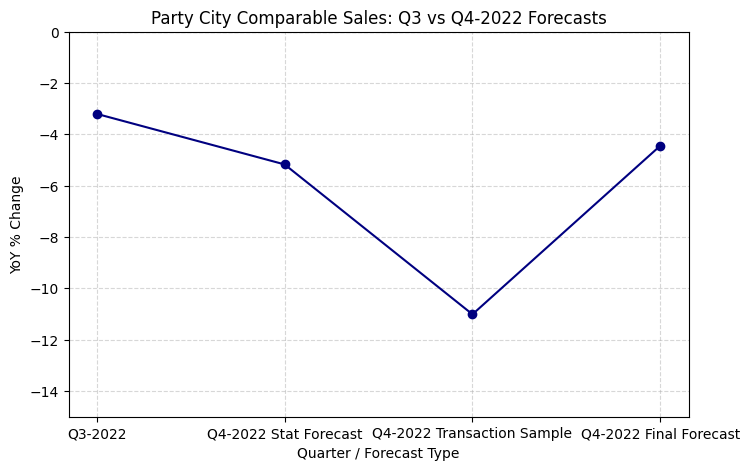

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Build a small dataframe for the chart
data = pd.DataFrame({
    "Quarter": ["Q3-2022", "Q4-2022 Stat Forecast", "Q4-2022 Transaction Sample", "Q4-2022 Final Forecast"],
    "Comp YoY %": [
        -3.2,          # Q3 2022 reported
        -5.17,         # Stat forecast
        -11.01,        # Transaction-implied
        -4.44          # Final weighted forecast
    ]
})

# Plot
plt.figure(figsize=(8,5))
plt.plot(data["Quarter"], data["Comp YoY %"], marker='o', linestyle='-', color='navy', label='YoY % Change')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # baseline
plt.title("Party City Comparable Sales: Q3 vs Q4-2022 Forecasts")
plt.ylabel("YoY % Change")
plt.xlabel("Quarter / Forecast Type")
plt.ylim(-15, 0)  # keep chart focused
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()